In [1]:
import pennylane as qml
import random
import os
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
os.chdir('../')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device='cpu'

In [4]:
print(device)

cpu


# Quantum Circuit

In [5]:
date = '20211124_111940'

resume_iters = 30

test_sample_size = 20000

layer = 3

qubits = 8

In [6]:
dev = qml.device('default.qubit', wires=qubits)
@qml.qnode(dev, interface='torch', diff_method='backprop')
def gen_circuit(w):
    # random noise as generator input
    z1 = random.uniform(-1, 1)
    z2 = random.uniform(-1, 1)
    
    # construct generator circuit for both atom vector and node matrix
    for i in range(qubits):
        qml.RY(np.arcsin(z1), wires=i)
        qml.RZ(np.arcsin(z2), wires=i)
    for l in range(layer):
        for i in range(qubits):
            qml.RY(w[i], wires=i)
        for i in range(qubits-1):
            qml.CNOT(wires=[i, i+1])
            qml.RZ(w[i+qubits], wires=i+1)
            qml.CNOT(wires=[i, i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

In [7]:
model_dir_path = r'/home/ken/projects/QuantumGAN-PyTorch/results/quantum-GAN/'+date+'/train/model_dir'

weights_pth = os.path.join(model_dir_path, 'molgan_red_weights.csv')

weights = pd.read_csv(weights_pth, header=None).iloc[resume_iters-1, 1:].values

gen_weights = torch.tensor(list(weights), requires_grad=True)

In [8]:
drawer = qml.draw(gen_circuit)
print(drawer(gen_weights))

 0: ──RY(-0.579)──RZ(-0.728)──RY(2.54)────╭C──────────────╭C───RY(2.54)────────────────────────────╭C───────────────────────╭C───────────RY(2.54)──────────────────────────────────────╭C───────────────────────╭C───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ ⟨Z⟩ 
 1: ──RY(-0.579)──RZ(-0.728)──RY(-1.72)───╰X──RZ(-0.421)──╰X──╭C───────────────────╭C───RY(-1.72)──╰X───────────RZ(-0.421)──╰X──────────╭C────────────────────╭C────────────RY(-1.72)──╰X───────────RZ(-0.421)──╰X──────────╭C─────────────────────╭C────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ ⟨Z⟩ 
 2: ──RY(-0.579)──RZ(-0.728)──RY(-1.83)───────────────────────╰X─────────RZ(1.13)──╰X──╭C──────────────────────╭C────────────RY(-1.83)──╰X──────────RZ(1.13)──╰X───────────╭C──────────────────────╭C───────────

In [9]:
sample_list = [gen_circuit(gen_weights) for i in range(test_sample_size)]

In [10]:
sample_list[0]

tensor([-0.1411, -0.6912, -0.3660,  0.6387, -0.7275, -0.6567,  0.0964,  0.4796],
       dtype=torch.float64, grad_fn=<CatBackward>)

# Data

In [11]:
from data.sparse_molecular_dataset import SparseMolecularDataset

In [12]:
mol_data_dir = 'data/gdb9_9nodes.sparsedataset'

In [13]:
data = SparseMolecularDataset()

data.load(mol_data_dir)

# Generator

In [14]:
from models.models import Generator, Discriminator

In [15]:
complexity = 'mr'

z_dim = qubits

dropout = 0.0

In [16]:
if complexity == 'nr':
    g_conv_dim = [128, 256, 512]
elif complexity == 'mr':
    g_conv_dim = [128]
elif complexity == 'hr':
    g_conv_dim = [16]
else:
    raise ValueError("Please enter an valid model complexity from 'mr', 'hr' or 'nr'!")

In [17]:
G = Generator(g_conv_dim, z_dim, data.vertexes, data.bond_num_types, data.atom_num_types, dropout)

In [18]:
G.to(device)

Generator(
  (activation_f): Tanh()
  (multi_dense_layers): MultiDenseLayers(
    (activation): Tanh()
    (linear_layers): Sequential(
      (0): Linear(in_features=8, out_features=128, bias=True)
      (1): Tanh()
      (2): Dropout(p=0.0, inplace=False)
    )
  )
  (edges_layer): Linear(in_features=128, out_features=405, bias=True)
  (nodes_layer): Linear(in_features=128, out_features=45, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [19]:
G_path = os.path.join(model_dir_path, '{}-G.ckpt'.format(resume_iters))

In [20]:
G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))

<All keys matched successfully>

# Generating Molecules

In [21]:
import torch.nn.functional as F

In [22]:
z = torch.stack(tuple(sample_list)).to(device).float()

In [23]:
post_method = 'softmax'

In [24]:
edges_logits, nodes_logits = G(z)

In [25]:
def postprocess(inputs, method, temperature=1.0):
    def listify(x):
        return x if type(x) == list or type(x) == tuple else [x]
    def delistify(x):
        return x if len(x) > 1 else x[0]
    if method == 'soft_gumbel':
        softmax = [F.gumbel_softmax(e_logits.contiguous().view(-1, e_logits.size(-1))/temperature, hard=False).view(e_logits.size()) for e_logits in listify(inputs)]
    elif method == 'hard_gumbel':
        softmax = [F.gumbel_softmax(e_logits.contiguous().view(-1, e_logits.size(-1))/temperature, hard=True).view(e_logits.size()) for e_logits in listify(inputs)]
    else:
        softmax = [F.softmax(e_logits/temperature, -1) for e_logits in listify(inputs)]
    return [delistify(e) for e in (softmax)]

In [26]:
(edges_hat, nodes_hat) = postprocess((edges_logits, nodes_logits), post_method)   

In [27]:
def get_gen_mols(data, n_hat, e_hat, method):
    (edges_hard, nodes_hard) = postprocess((e_hat, n_hat), method)
    edges_hard, nodes_hard = torch.max(edges_hard, -1)[1], torch.max(nodes_hard, -1)[1]
    mols = [data.matrices2mol(n_.data.cpu().numpy(), e_.data.cpu().numpy(), strict=True) for e_, n_ in zip(edges_hard, nodes_hard)]
    return mols

In [28]:
mols = get_gen_mols(data, nodes_logits, edges_logits, post_method)

RDKit ERROR: [18:10:03] non-ring atom 4 marked aromatic
[18:10:03] non-ring atom 4 marked aromatic
RDKit ERROR: [18:10:03] non-ring atom 1 marked aromatic
[18:10:03] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:03] non-ring atom 1 marked aromatic
[18:10:03] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:03] non-ring atom 3 marked aromatic
[18:10:03] non-ring atom 3 marked aromatic
RDKit ERROR: [18:10:03] non-ring atom 2 marked aromatic
RDKit ERROR: [18:10:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:03] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:03] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:03] non-ring atom 2 marked aromatic
[18:10:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6

[18:10:03] non-ring atom 1 marked aromatic
[18:10:03] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:03] Can't kekulize mol.  Unkekulized atoms: 2 4 6
RDKit ERROR: 
[18:10:03] Ca

[18:10:03] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:03] non-ring atom 2 marked aromatic
[18:10:03] non-ring atom 2 marked aromatic
RDKit ERROR: [18:10:03] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:03] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
[18:10:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6

RDKit ERROR: 
RDKit ERROR: [18:10:03] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:03] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:03] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:03] Explicit valence for atom # 8 C, 5, is greater than permitted
RDKit ERROR: [18:10:03] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:03] non-ring atom 5 marked aromatic
[18:10:03] Can't k

[18:10:03] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:03] Can't kekulize mol.  Unkekulized atoms: 6

[18:10:03] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6

[18:10:03] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:03] non-ring atom 2 marked aromatic
RDKit ERROR: [18:10:03] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:03] non-ring atom 4 marked aromatic
RDKit ERROR: [18:10:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:03] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:03] non-ring atom 1 marked aromatic
[18:10:03] non-ring atom 4 marked aromatic
[18:10:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6

RDKit ERROR: [18:10:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:03] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:03] non-ring atom 2 mark

RDKit ERROR: [18:10:03] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [18:10:03] non-ring atom 2 marked aromatic
RDKit ERROR: [18:10:03] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:03] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:03] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [18:10:03] non-ring atom 4 marked aromatic
RDKit ERROR: [18:10:03] Can't kekulize mol.  Unkekulized atoms: 2 4 6
RDKit ERROR: 
RDKit ERROR: [18:10:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
[18:10:03] Explicit valence for atom # 8 C, 5, is greater than permitted
[18:10:03] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:03] non-ring atom 1 marked aromatic
[18:10:03] non-ring atom 1 marked aromatic
[18:10:03] Explicit valence for atom # 7 O, 3, is greater than permitted
[18:10:03] non-ring atom 2 marked aromatic
[18:10:03] non-ring atom 1 marked aromatic
[18:10:03] 

RDKit ERROR: [18:10:03] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:03] Explicit valence for atom # 3 O, 3, is greater than permitted
[18:10:03] non-ring atom 2 marked aromatic
[18:10:03] non-ring atom 0 marked aromatic
RDKit ERROR: [18:10:03] Can't kekulize mol.  Unkekulized atoms: 2 4 6
RDKit ERROR: 
RDKit ERROR: [18:10:03] non-ring atom 2 marked aromatic
RDKit ERROR: [18:10:03] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:03] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:03] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:03] Can't kekulize mol.  Unkekulized atoms: 0
RDKit ERROR: 
RDKit ERROR: [18:10:03] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [18:10:03] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:03] Can't kekulize mol.  Unkekulized atoms: 0
RDKit ERROR: 
RDKit ERROR: [18:10:03] non-ring atom 2 marked aromatic
[18:10:03] Can't kekulize mol.  Unkekulized 

RDKit ERROR: [18:10:04] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:04] Can't kekulize mol.  Unkekulized atoms: 2 4 6
RDKit ERROR: 
RDKit ERROR: [18:10:04] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:04] non-ring atom 1 marked aromatic
[18:10:04] Can't kekulize mol.  Unkekulized atoms: 2 4 6

[18:10:04] non-ring atom 1 marked aromatic
[18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:04] 

[18:10:04] non-ring atom 1 marked aromatic
[18:10:04] non-ring atom 4 marked aromatic
[18:10:04] Explicit valence for atom # 3 O, 3, is greater than permitted
[18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:04] Explicit valence for atom # 5 O, 3, is greater than permitted
[18:10:04] non-ring atom 4 marked aromatic
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:04] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:04] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:04] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:04] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [18:10:04] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:04] non-ring atom 2 marked aromatic
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] Ex

RDKit ERROR: [18:10:04] Can't kekulize mol.  Unkekulized atoms: 2 4 6
[18:10:04] non-ring atom 1 marked aromatic
[18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:04] non-ring atom 1 marked aromatic
[18:10:04] non-ring atom 5 marked aromatic
[18:10:04] Explicit valence for atom # 8 C, 5, is greater than permitted
[18:10:04] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: 
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] Can't kekulize mol.  Unkekulized atoms: 2 4 6
RDKit ERROR: 
RDKit ERROR: [18:10:04] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:04] Can't kekulize mol.  Unkekulized atoms: 2 4 6

[18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:

[18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:04] non-ring atom 1 marked aromatic
[18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
[18:10:04] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6

RDKit ERROR: 
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] non-ring atom 4 marked aromatic
RDKit ERROR: [18:10:04] Can't kekulize mol.  Unkekulized atoms: 0
RDKit ERROR: 
[18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] Explicit valence for atom # 1 C, 5, is gr

[18:10:04] Can't kekulize mol.  Unkekulized atoms: 5

[18:10:04] Explicit valence for atom # 2 C, 5, is greater than permitted
[18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:04] non-ring atom 4 marked aromatic
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:04] Can't kekulize mol.  Unkekulized atoms: 2 4 6
RDKit ERROR: 
RDKit ERROR: [18:10:04] Can't kekulize mol.  Unkekulized atoms: 2 4 6
RDKit ERROR: 
RDKit ERROR: [18:10:04] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [18:10:04] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:04] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:04] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:04] Explicit valence for atom # 0 O, 3, is greater than

RDKit ERROR: 
RDKit ERROR: [18:10:05] non-ring atom 4 marked aromatic
[18:10:05] non-ring atom 1 marked aromatic
[18:10:05] non-ring atom 1 marked aromatic
[18:10:05] Can't kekulize mol.  Unkekulized atoms: 2 4 6

RDKit ERROR: [18:10:05] Can't kekulize mol.  Unkekulized atoms: 2 4 6
RDKit ERROR: 
RDKit ERROR: [18:10:05] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:05] Explicit valence for atom # 3 O, 3, is greater than permitted
[18:10:05] non-ring atom 4 marked aromatic
[18:10:05] Can't kekulize mol.  Unkekulized atoms: 2 4 6

RDKit ERROR: [18:10:05] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:05] Can't kekulize mol.  Unkekulized atoms: 2 4 6
[18:10:05] non-ring atom 1 marked aromatic
[18:10:05] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: 
[18:10:05] non-ring atom 1 marked aromatic
[18:10:05] Can't kekulize mol.  Unkekulized atoms: 2 4 6

RDKit ERROR: [18:10:05] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
[18:10:05] Can

RDKit ERROR: [18:10:05] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [18:10:05] Can't kekulize mol.  Unkekulized atoms: 2 4 6
RDKit ERROR: 
RDKit ERROR: [18:10:05] non-ring atom 2 marked aromatic
RDKit ERROR: [18:10:05] Can't kekulize mol.  Unkekulized atoms: 2 4 6
RDKit ERROR: 
RDKit ERROR: [18:10:05] non-ring atom 4 marked aromatic
RDKit ERROR: [18:10:05] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:05] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:05] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:05] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:05] non-ring atom 4 marked aromatic
[18:10:05] Explicit valence for atom # 7 N, 4, is greater than permitted
[18:10:05] non-ring atom 1 marked aromatic
[18:10:05] non-ring atom 1 marked aromatic
[18:10:05] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6

[18:10:05] non-ring atom 2 marked aromatic
[18:10:05] non-ring atom 1 m

[18:10:05] Explicit valence for atom # 5 O, 3, is greater than permitted
[18:10:05] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:05] non-ring atom 0 marked aromatic
[18:10:05] non-ring atom 0 marked aromatic
RDKit ERROR: [18:10:05] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:05] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:05] non-ring atom 1 marked aromatic
[18:10:05] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6

RDKit ERROR: [18:10:05] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [18:10:05] Can't kekulize mol.  Unkekulized atoms: 2 4 6
[18:10:05] non-ring atom 1 marked aromatic
[18:10:05] non-ring atom 1 marked aromatic
[18:10:05] Explicit valence for atom # 7 C, 5, is greater than permitted
[18:10:05] Can't kekulize mol.  Unkekulized atoms: 2 4 6

RDKit ERROR: 
RDKit ERROR: [18:10:05] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:05] Can't kekulize mol.  Unkek

RDKit ERROR: [18:10:05] non-ring atom 1 marked aromatic
[18:10:05] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:05] non-ring atom 1 marked aromatic
[18:10:05] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:05] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
[18:10:05] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6

RDKit ERROR: [18:10:05] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:05] non-ring atom 1 marked aromatic
[18:10:05] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:05] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:05] non-ring atom 2 marked aromatic
RDKit ERROR: [18:10:05] non-ring atom 4 marked aromatic
[18:10:05] non-ring atom 1 marked aromatic
[18:10:05] non-ring atom 1 marked aromatic
[18:10:05] non-ring atom 2 marked aromatic
[18:10:05] non-ring atom 4 marked aromatic
RDKit ERROR: [18:10:05] non-ring atom 1 marked aromatic
[18:10:05] non-ring atom 1 marked aromati

RDKit ERROR: [18:10:05] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:05] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:05] non-ring atom 0 marked aromatic
RDKit ERROR: [18:10:05] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:05] Can't kekulize mol.  Unkekulized atoms: 2 4 6
RDKit ERROR: 
RDKit ERROR: [18:10:05] Explicit valence for atom # 0 O, 3, is greater than permitted
arked aromatic
[18:10:05] non-ring atom 2 marked aromatic
[18:10:05] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:05] Explicit valence for atom # 7 C, 5, is greater than permitted
[18:10:05] non-ring atom 2 marked aromatic
[18:10:05] Explicit valence for atom # 3 O, 3, is greater than permitted
[18:10:05] non-ring atom 1 marked aromatic
[18:10:05] Explicit valence for atom # 7 C, 5, is greater than permitted
[18:10:05] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6

[18:10:05] non-ring atom 1 marked aromatic
[

[18:10:06] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:06] non-ring atom 1 marked aromatic
[18:10:06] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:06] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:06] Explicit valence for atom # 3 O, 3, is greater than permitted
[18:10:06] Can't kekulize mol.  Unkekulized atoms: 2 4 6

[18:10:06] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:06] Can't kekulize mol.  Unkekulized atoms: 2 4 6

[18:10:06] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:06] Can't kekulize mol.  Unkekulized atoms: 2 4 6
RDKit ERROR: 
RDKit ERROR: [18:10:06] non-ring atom 4 marked aromatic
[18:10:06] Can't kekulize mol.  Unkekulized atoms: 2 4 6

RDKit ERROR: [18:10:06] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:06] Can't kekulize mol.  Unkekulized atoms: 2 4 6
RDKit ERROR: 
RDKit ERROR: [18:10:06] non-ring atom 0 marked aromatic
RDKit ERROR: [18:10:06] Can't kekulize 

RDKit ERROR: [18:10:06] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:06] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:06] non-ring atom 4 marked aromatic
[18:10:06] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:06] non-ring atom 4 marked aromatic
RDKit ERROR: [18:10:06] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:06] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [18:10:06] Explicit valence for atom # 7 C, 5, is greater than permitted
RDKit ERROR: [18:10:06] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:06] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [18:10:06] Explicit valence for atom # 2 C, 5, is greater than permitted
RDKit ERROR: [18:10:06] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:06] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [18:10:06] non-ring atom 2 marked aromatic
[18:10:06] non-

RDKit ERROR: [18:10:06] non-ring atom 4 marked aromatic
RDKit ERROR: [18:10:06] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:06] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:06] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:06] non-ring atom 1 marked aromatic
[18:10:06] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:06] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:10:06] non-ring atom 1 marked aromatic
[18:10:06] non-ring atom 1 marked aromatic
[18:10:06] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:06] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:06] non-ring atom 5 marked aromatic
RDKit ERROR: [18:10:06] non-ring atom 2 marked aromatic
RDKit ERROR: [18:10:06] non-ring atom 2 marked aromatic
RDKit ERROR: [18:10:06] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:06] Can't kekulize mol.  Unkekuliz

[18:10:06] Can't kekulize mol.  Unkekulized atoms: 1 4 5 6 7

[18:10:06] non-ring atom 1 marked aromatic
[18:10:06] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:06] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:06] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:06] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:06] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:06] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:06] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:06] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:06] Explicit valence for atom # 5 O, 3, is greater than permitted
RDKit ERROR: [18:10:06] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:06] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:06] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:06] non-ring atom 1 marked aro

RDKit ERROR: [18:10:07] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:07] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:07] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
RDKit ERROR: [18:10:07] Can't kekulize mol.  Unkekulized atoms: 4 6 7
RDKit ERROR: 
RDKit ERROR: [18:10:07] non-ring atom 1 marked aromatic
RDKit ERROR: [18:10:07] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:07] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [18:10:07] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6
RDKit ERROR: 
[18:10:07] non-ring atom 1 marked aromatic
[18:10:07] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6

[18:10:07] non-ring atom 1 marked aromatic
[18:10:07] Can't kekulize mol.  Unkekulized atoms: 1 2 4 5 6

[18:10:07] Can't kekulize mol.  Unkekulized atoms: 4 6 7

RDKit ERROR: [18:10:07] non-ring atom 2 marked aromatic
RDKit ERROR: [18:10:07] non-ring atom 4 mark

# Scores

In [29]:
from utils.utils import *

In [30]:
m0, m1 = all_scores(mols, data, norm=True)

In [31]:
data = m0['drugcand']
data_avg = sum(data)/len(data)
data_std = np.std(data)

Text(0.2, 6, 'mean: 0.42, std: 0.19')

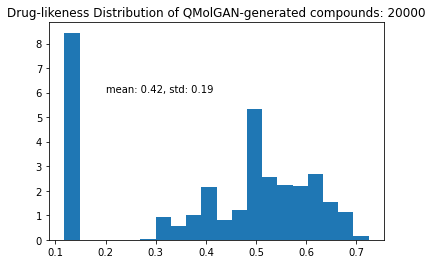

In [32]:
plt.hist(data, bins=20, density=True)
plt.title('Drug-likeness Distribution of QMolGAN-generated compounds: {}'.format(test_sample_size))
plt.text(0.2, 6, 'mean: {:.2f}, std: {:.2f}'.format(data_avg, data_std))

In [33]:
from collections import defaultdict

scores = defaultdict(list)

for k, v in m1.items():
    scores[k].append(v)
for k, v in m0.items():
    scores[k].append(np.array(v)[np.nonzero(v)].mean())

In [34]:
scores

defaultdict(list,
            {'valid': [74.40500259399414],
             'unique': [3.4473489684833005],
             'novel': [78.05927021033533],
             'NP': [0.9538510593137984],
             'QED': [0.48638556865378746],
             'Solute': [0.3160556685113756],
             'SA': [0.3357229513193808],
             'diverse': [0.5940350009095944],
             'drugcand': [0.4174663631638028]})

In [35]:
v = MolecularMetrics.valid_filter(mols)

In [36]:
s = set(map(lambda x: Chem.MolToSmiles(x), v))

In [37]:
print(len(s))

513


In [38]:
from rdkit.Chem import Draw

unique_mols = list(map(lambda x: Chem.MolFromSmiles(x), s))

In [39]:
img=Draw.MolsToGridImage(unique_mols,molsPerRow=8,subImgSize=(200,200), maxMols=500)    

/home/ken/anaconda3/envs/molgan-pt/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 500. Change the maxMols value to display more.
  % (maxMols))


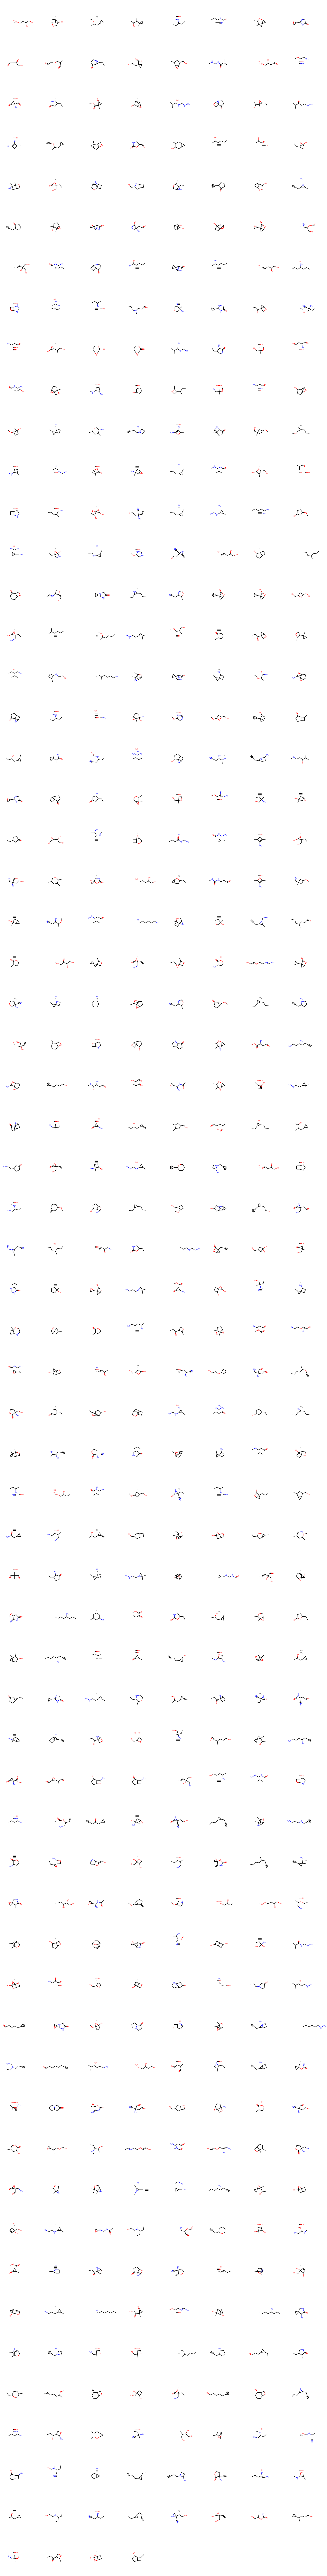

In [40]:
img

In [41]:
df = pd.DataFrame({'SMIELS': data} for data in s)

In [42]:
#df.to_csv('quantum-'+str(resume_iters)+'.csv', index=False)